## Setup

In [293]:
source("/path/to/the/project/02_notebooks/00_setup.r")

In [2]:
p_load("igraph", "STRINGdb", "org.Mm.eg.db", "biomaRt", "dplyr", "WGCNA", "DESeq2", "OmnipathR", "wppi", "RandomWalkRestartMH", install = FALSE)

## Network inputs

In [191]:
dds_all <- readRDS("03_outputs/03/dds_object_batch_group_wald.rds")

In [192]:
tfs_scored_combined <- read.csv(file = "03_outputs/13/tfs_scored.csv")

In [193]:
genes_overlaps <- read.csv("03_outputs/08/intersection_genes.csv")

### GCN (WGCNA_BIOTMLE_overlaps_TOM)

In [194]:
# i_pp <- read.csv("03_outputs/08/intersection_pp_genes.csv")
# i_cpa <- read.csv("03_outputs/08/intersection_cpa_genes.csv")
# i_cir <- read.csv("03_outputs/08/intersection_cir_genes.csv")
# i_reg <- read.csv("03_outputs/08/intersection_reg_genes.csv")
i_genes <- read.csv("03_outputs/08/intersection_genes.csv")
genes_up_down <- read.csv(file="03_outputs/03_2/ltr_genes_intercept_up_down.csv")
genes_up_up <- read.csv(file="03_outputs/03_2/ltr_genes_intercept_up_up.csv")
genes_down_up <- read.csv(file="03_outputs/03_2/ltr_genes_intercept_down_up.csv")
genes_down_down <- read.csv(file="03_outputs/03_2/ltr_genes_intercept_down_down.csv")
down_up_6k <- read.csv(file="03_outputs/03_2/ltr_genes_6k_down_up.csv")
down_down_6k <- read.csv(file="03_outputs/03_2/ltr_genes_6k_down_down.csv")
all_p_gs <- read.csv("03_outputs/07/all_genes_traits_value.csv")
# cir_score <- read.csv("03_outputs/03_2/genes_cirrhosis_score.csv")
# reg_score <- read.csv("03_outputs/03_2/genes_regression_score.csv")
all_df <- read.csv("03_outputs/03_2/scores_merged_dataframe.csv")

In [195]:
i_pp <- i_genes %>% filter(module == "PP")
i_cpa <- i_genes %>% filter(module == "CPA")
i_cir <- i_genes %>% filter(module == "Cirrhosis")
i_reg <- i_genes %>% filter(module == "Regression")

In [196]:
expr_preprocessed <- counts(dds_all)
expr_preprocessed <- expr_preprocessed %>% as.data.frame() %>% filter(row.names(.) %in% genes_overlaps$genes) %>% as.matrix()

In [197]:
expr_preprocessed <- varianceStabilizingTransformation(expr_preprocessed)
expr_preprocessed <- t(expr_preprocessed)

In [198]:
gsg_all = goodSamplesGenes(expr_preprocessed, verbose = 3)
gsg_all$allOK

if (!gsg_all$allOK)
{
if (sum(!gsg_all$goodGenes)>0)
printFlush(paste("Removing genes:", paste(names(expr_preprocessed)[!gsg_all$goodGenes], collapse = ", ")))
if (sum(!gsg_all$goodSamples)>0)
printFlush(paste("Removing samples:", paste(rownames(expr_preprocessed)[!gsg_all$goodSamples], collapse = ", ")))
expr_preprocessed = expr_preprocessed[gsg_all$goodSamples, gsg_all$goodGenes]
}

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

In [199]:
expr_of_interest_all <- expr_preprocessed
adjacency <- adjacency(expr_of_interest_all, power = wgcna_power_all)
TOM = TOMsimilarity(adjacency, TOMType="unsigned")
row.names(TOM) = colnames(expr_of_interest_all)
colnames(TOM) = colnames(expr_of_interest_all)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [200]:
edge_list_all <- as.data.frame(TOM) %>% dplyr::mutate(gene1 = row.names(.)) %>% tidyr::pivot_longer(-gene1) %>% 
                                dplyr::rename(gene2 = name, weight = value) #%>% dplyr::filter(weight > 0.3)

In [201]:
edge_list_all <- edge_list_all %>% mutate(node_of_interest = "NA")

In [202]:
i_pp_cpa <- as.vector(intersect(i_pp$genes, i_cpa$genes))
i_cpa_cir <- as.vector(intersect(i_cpa$genes, i_cir$genes))

In [203]:
edge_list_all <- edge_list_all %>% mutate(node_of_interest = "NA") %>%
                    mutate(node_of_interest = case_when(
                  gene1 %in% i_pp$genes ~ "biomarker_PP",
                  gene1 %in% i_cpa$genes ~ "biomarker_CPA",
                  gene1 %in% i_cir$genes ~ "biomarker_CIR",
                  gene1 %in% i_reg$genes ~ "biomarker_REG",
                  .default = as.character(node_of_interest)
)) %>%   
                mutate(node_of_interest = case_when(gene1 %in% i_pp_cpa ~ "biomarker_PP_CPA", 
                .default = as.character(node_of_interest))) %>% 
                mutate(node_of_interest = case_when(gene1 %in% i_cpa_cir ~ "biomarker_CPA_CIR",
                .default = as.character(node_of_interest)))

In [204]:
edge_list_all_prep <- edge_list_all %>% rename(gcn_weight = weight) %>% rename(from = gene1) %>% 
                        rename(to = gene2) 

In [205]:
genes_up_down <- genes_up_down$up_down.genes
genes_up_up <- genes_up_up$up_up.genes
genes_down_up <- genes_down_up$down_up.genes
genes_down_down <- genes_down_down$down_down.genes

In [206]:
down_up_6k <- down_up_6k$down_up_6k.genes
down_down_6k <- down_down_6k$down_down_6k.genes

In [207]:
length(genes_down_up)

[1] 1225

In [208]:
edge_list_all_prep <- edge_list_all_prep %>% mutate(dynamic_pattern = "NA") %>%
                    mutate(dynamic_pattern = case_when(
                  from %in% genes_up_down ~ "up_down",
                  from %in% genes_up_up ~ "up_up",
                  from %in% down_up_6k ~ "down_up",
                  from %in% down_down_6k ~ "down_down",
                  .default = as.character(dynamic_pattern)
))

In [209]:
genes_gs_prep <- all_p_gs %>% filter(gene %in% edge_list_all_prep$from) %>% select(gene, GS.PP, GS.CPA) %>% rename(from = gene) %>% arrange(GS.PP)
edge_list_all_prep <- merge(edge_list_all_prep, genes_gs_prep, by = "from", all = TRUE)

In [210]:
prep_cir_reg <- all_df %>% select(-X) %>% rename(from = gene) %>% filter(from %in% edge_list_all_prep$from)
edge_list_all_prep <- merge(edge_list_all_prep, prep_cir_reg, by = "from", all = TRUE) 

In [23]:
write.csv(edge_list_all,
            file = "03_outputs/14/gcn_input.csv",
            quote = FALSE)

### GRN (TF - overlaps)

In [215]:
tfs_scored_combined_prep <- tfs_scored_combined %>% rename(from = regulatoryGene) %>% rename(to = targetGene) %>% mutate(node_of_interest = "tf") %>% select(from, to, node_of_interest)

In [216]:
tfs_scored_combined_prep <- tfs_scored_combined_prep %>% filter(!to %in% c("Emp1", "Fam180a", "Fam177a2", "Fam177a", "Fam163b", "Ptk7", "Gpnmb", "Cavin3")) %>% 
                                                        filter(!from %in% c("Emp1", "Fam180a", "Fam177a2", "Fam177a", "Fam163b", "Ptk7", "Gpnmb", "Cavin3"))

In [26]:
gcn_grn <- merge(edge_list_all_prep, tfs_scored_combined_prep, by = c("from", "to", "node_of_interest"), all = TRUE) %>% arrange(node_of_interest) 

In [29]:
gcn_grn$gcn_weight <- gcn_grn$gcn_weight %>% tidyr::replace_na(0.0001)
gcn_grn$GS.PP <- gcn_grn$GS.PP %>% tidyr::replace_na(0)
gcn_grn$GS.CPA <- gcn_grn$GS.CPA %>% tidyr::replace_na(0)
gcn_grn$cirrhosis_score <- gcn_grn$cirrhosis_score %>% tidyr::replace_na(0)
gcn_grn$regression_score <- gcn_grn$regression_score %>% tidyr::replace_na(0)

In [31]:
write.csv(gcn_grn, file = "03_outputs/14/grn_gcn.csv", quote = FALSE)

### OmnipathR PPI

In [ ]:
grn_gcn <- grn_gcn %>% filter(!from %in% tfs)
genes_interest <- unique(grn_gcn$from)
interactions <- import_omnipath_interactions(organism = 10090)
enzsub <- import_omnipath_enzsub(organism = 10090)
interactions_selected <- interactions %>% subset(source_genesymbol %in% genes_interest | target_genesymbol %in% genes_interest)
enzsub_selected <- enzsub %>% subset(enzyme_genesymbol %in% genes_interest | substrate_genesymbol %in% genes_interest)
enzsub_selected <- enzsub_selected %>% select(c(enzyme_genesymbol, substrate_genesymbol, modification)) %>% rename(from = enzyme_genesymbol, to = substrate_genesymbol)
interactions_selected <- interactions_selected %>% rename(from = source_genesymbol, to = target_genesymbol) %>% mutate(type_of_interaction = NA) %>% 
                          mutate(type_of_interaction = case_when(
                          is_stimulation == "1" ~ "stimulates",
                          is_inhibition == "-1" ~ "inhibits",
                          .default = (type_of_interaction)
)) %>% select(from, to, type_of_interaction)

omnipath_merged <- merge(interactions_selected, enzsub_selected, by = c("from", "to"), all = TRUE)
omnipath_merged$type_of_interaction <- omnipath_merged$type_of_interaction %>% tidyr::replace_na(NA)

### Merged network

In [ ]:
gcn_grn_ppi <- merge(gcn_grn, omnipath_merged, by = c("from", "to"), all = TRUE)

In [105]:
#gcn_grn_ppi <- read.csv("03_outputs/14/gcn_grn_ppi.csv")

## Outputs (for further processing in Cytoscape)

In [55]:
# write.csv(edgelist_directed, "03_outputs/14/edgelist_directed.csv", quote = FALSE)
# write.csv(gcn_grn_ppi, "03_outputs/14/grn_gcn_ppi.csv", quote = FALSE)

In [46]:
write.csv(gcn_grn, "03_outputs/14/grn_gcn.csv", quote = FALSE)
# gcn_grn <- read.csv("03_outputs/14/grn_gcn.csv")

## RWR analysis (post-Cytoscape)

In [105]:
ppi_layer <- read.csv("03_outputs/14/ppin_edges.csv")
ppi_layer <- ppi_layer %>% rename(weight = weight_e) %>% select(-c(weight_c, stringdb))
gcn_layer <- edge_list_all_prep %>% filter(!node_of_interest == "tf") %>% select(from, to, gcn_weight, node_of_interest) %>% rename(weight = gcn_weight) %>% distinct()
grn_layer <- gcn_grn %>% select(from, to, node_of_interest) %>% filter(node_of_interest == "tf")

In [108]:
tf_pp_score <- tfs_scored_combined %>% mutate(tf_score_pp = scales::rescale(tf_score_pp, to = c(0, 1))) %>% select(regulatoryGene, targetGene, tf_score_pp) %>% rename(from = regulatoryGene, to = targetGene) %>% tidyr::drop_na() %>% rename(weight = tf_score_pp)
tf_cpa_score <- tfs_scored_combined %>% mutate(tf_score_cpa = scales::rescale(tf_score_cpa, to = c(0, 1))) %>% select(regulatoryGene, targetGene, tf_score_cpa) %>% rename(from = regulatoryGene, to = targetGene) %>% tidyr::drop_na() %>% rename(weight = tf_score_cpa)
tf_cir_score <- tfs_scored_combined %>% mutate(tf_score_cir = scales::rescale(tf_score_cir, to = c(0, 1))) %>% select(regulatoryGene, targetGene, tf_score_cir) %>% rename(from = regulatoryGene, to = targetGene) %>% tidyr::drop_na() %>% rename(weight = tf_score_cir)
tf_reg_score <- tfs_scored_combined %>% mutate(tf_score_reg = scales::rescale(tf_score_reg, to = c(0, 1))) %>% select(regulatoryGene, targetGene, tf_score_reg) %>% rename(from = regulatoryGene, to = targetGene) %>% tidyr::drop_na() %>% rename(weight = tf_score_reg)

In [ ]:
ppi_layer <- ppi_layer %>% tidyr::drop_na()

### PP

In [148]:
gcn_layer_pp <- gcn_layer %>% filter(node_of_interest %in% c("biomarker_PP", "biomarker_PP_CPA")) %>% select(-node_of_interest)

gcn_layer_pp <- gcn_layer_pp %>% tidyr::drop_na()
tf_pp_score <- tf_pp_score %>% tidyr::drop_na()

i_ppin <- graph_from_data_frame(ppi_layer, directed = TRUE)
i_gcn <- graph_from_data_frame(gcn_layer_pp, directed = TRUE)
i_grn <- graph_from_data_frame(tf_pp_score, directed = TRUE)

In [149]:
seed_genes <- tf_pp_score %>% select(from) %>% distinct()
seed_genes <- seed_genes$from
seed_genes

[1] "Hmga1"   "Rxrb"    "Safb"    "Srebf2"  "Nr1h2"   "Tcf4"    "Klf15"  
 [8] "Mafk"    "Rbck1"   "Irf9"    "Gpbp1l1" "Mbd3"    "Irf7"    "Atf5"   
[15] "Preb"    "Nme2"    "Hmg20b"  "Chchd3"  "Ahdc1"

In [150]:
multilayer_net <- 
  create.multiplex(list(GRN = i_grn,GCN = i_gcn, PPIN = i_ppin))
adj_matrix <- compute.adjacency.matrix(multilayer_net)
adj_matrix_norm <- normalize.multiplex.adjacency(adj_matrix)
rwr_results <- Random.Walk.Restart.Multiplex(adj_matrix_norm,
                        multilayer_net,seed_genes)

Warning message in v(graph):
"Non-positive edge weight found, ignoring all weights during graph layout."


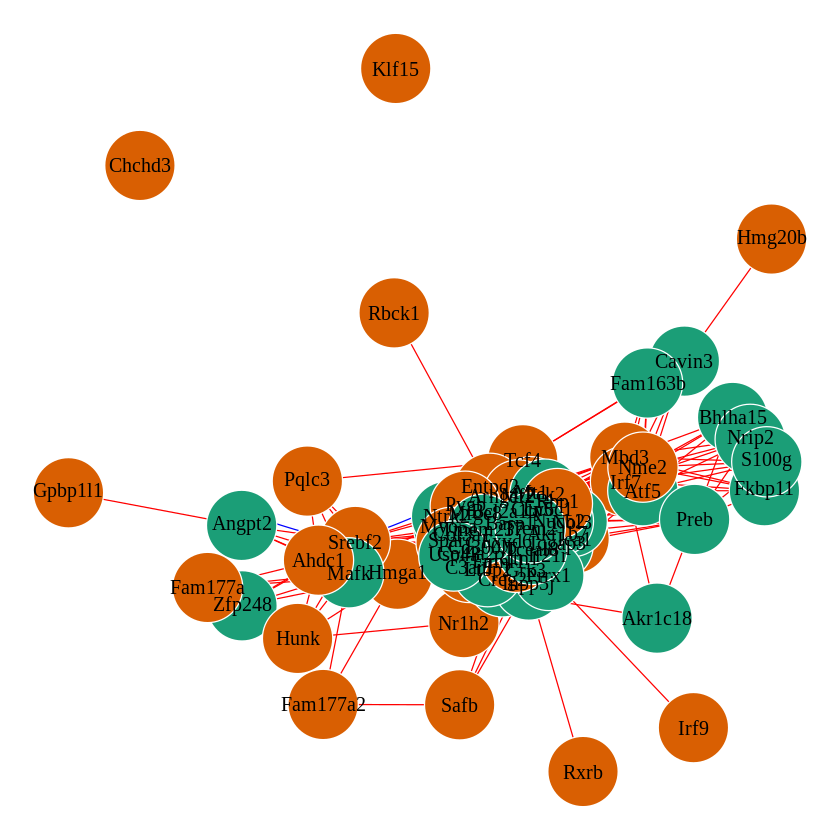

In [151]:
rwr_topresults <-
    create.multiplexNetwork.topResults(rwr_results, multilayer_net, 
      k=50)

library(RColorBrewer)
pal <- brewer.pal(3, "Dark2")

par(mar=c(0.1,0.1,0.1,0.1))
plot(rwr_topresults, vertex.label.color="black",
    vertex.frame.color="#ffffff", vertex.size= 20,
    edge.curved= ifelse(E(rwr_topresults)$type == "PPIN",
                    0.4,0),
    vertex.color = pal[as.numeric(as.factor((E(rwr_topresults)$type)))],
    edge.color=ifelse(E(rwr_topresults)$type == "PPIN",
                      "blue","red"))

In [152]:
rwr_results_pp <- rwr_results$RWRM_Results

### R

In [156]:
gcn_layer_reg <- gcn_layer %>% filter(node_of_interest %in% c("biomarker_REG")) %>% select(-node_of_interest) %>% tidyr::drop_na()
tf_reg_score <- tf_reg_score %>% tidyr::drop_na()

i_ppin <- graph_from_data_frame(ppi_layer, directed = TRUE)
i_gcn <- graph_from_data_frame(gcn_layer_reg, directed = TRUE)
i_grn <- graph_from_data_frame(tf_reg_score, directed = TRUE)

In [157]:
i_ppin <- graph_from_data_frame(ppi_layer, directed = TRUE)
i_gcn <- graph_from_data_frame(gcn_layer_reg, directed = TRUE)
i_grn <- graph_from_data_frame(grn_layer, directed = TRUE)

In [155]:
seed_genes <- tf_reg_score %>% select(from) %>% distinct()
seed_genes <- seed_genes$from
seed_genes

[1] "Nr1h2"  "Tcf4"   "Mafk"   "Zfp445" "Nfib"   "Ahdc1"

In [158]:
multilayer_net <- 
  create.multiplex(list(GRN = i_grn,GCN = i_gcn, PPIN = i_ppin))
adj_matrix <- compute.adjacency.matrix(multilayer_net)
adj_matrix_norm <- normalize.multiplex.adjacency(adj_matrix)
rwr_results <- Random.Walk.Restart.Multiplex(adj_matrix_norm,
                        multilayer_net,seed_genes)

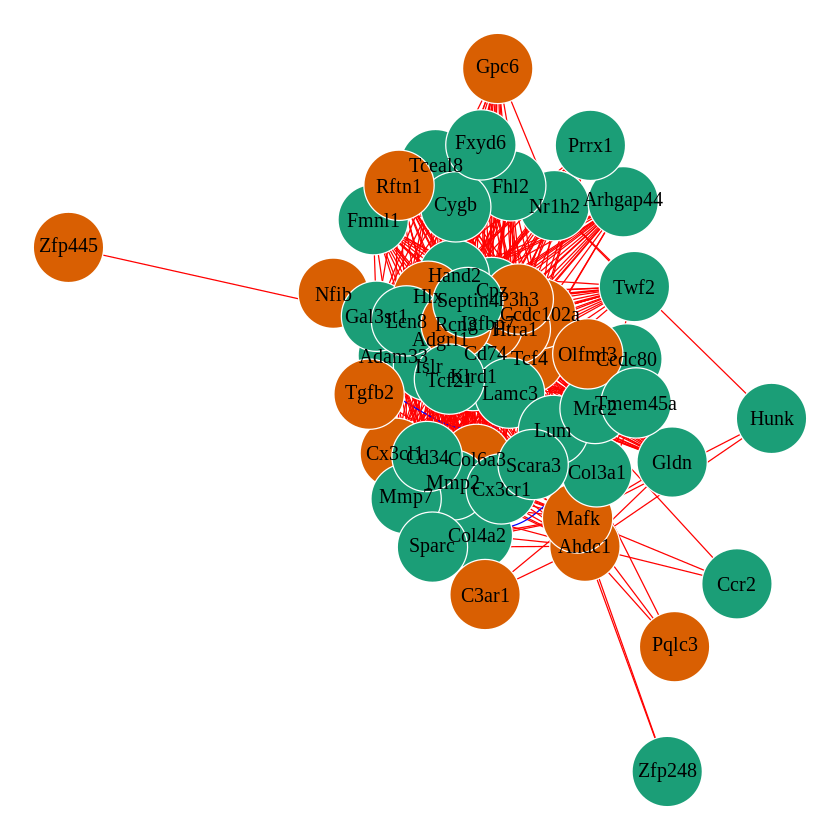

In [159]:
rwr_topresults <-
    create.multiplexNetwork.topResults(rwr_results, multilayer_net, 
      k=50)

library(RColorBrewer)
pal <- brewer.pal(3, "Dark2")

par(mar=c(0.1,0.1,0.1,0.1))
plot(rwr_topresults, vertex.label.color="black",
    vertex.frame.color="#ffffff", vertex.size= 20,
    edge.curved= ifelse(E(rwr_topresults)$type == "PPIN",
                    0.4,0),
    vertex.color = pal[as.numeric(as.factor((E(rwr_topresults)$type)))],
    edge.color=ifelse(E(rwr_topresults)$type == "PPIN",
                      "blue","red"))

In [160]:
rwr_results_reg <- rwr_results$RWRM_Results

### CIR

In [163]:
gcn_layer_cir <- gcn_layer %>% filter(node_of_interest %in% c("biomarker_CIR", "biomarker_CPA_CIR")) %>% select(-node_of_interest) %>% tidyr::drop_na()
tf_cir_score <- tf_cir_score %>% tidyr::drop_na()

i_ppin <- graph_from_data_frame(ppi_layer, directed = TRUE)
i_gcn <- graph_from_data_frame(gcn_layer_cir, directed = TRUE)
i_grn <- graph_from_data_frame(tf_cir_score, directed = TRUE)

In [164]:
seed_genes <- tf_cir_score %>% select(from) %>% distinct()
seed_genes <- seed_genes$from
seed_genes

[1] "Hmga1"   "Srebf2"  "Nr1h2"   "Tcf4"    "Klf15"   "Mafk"    "Gpbp1l1"
 [8] "Mbd3"    "Irf7"    "Atf5"    "Nme2"    "Ahdc1"   "Stat6"   "Kdm5b"

In [165]:
multilayer_net <- 
  create.multiplex(list(GRN = i_grn,GCN = i_gcn, PPIN = i_ppin))
adj_matrix <- compute.adjacency.matrix(multilayer_net)
adj_matrix_norm <- normalize.multiplex.adjacency(adj_matrix)
rwr_results <- Random.Walk.Restart.Multiplex(adj_matrix_norm,
                        multilayer_net,seed_genes)

Warning message in v(graph):
"Non-positive edge weight found, ignoring all weights during graph layout."


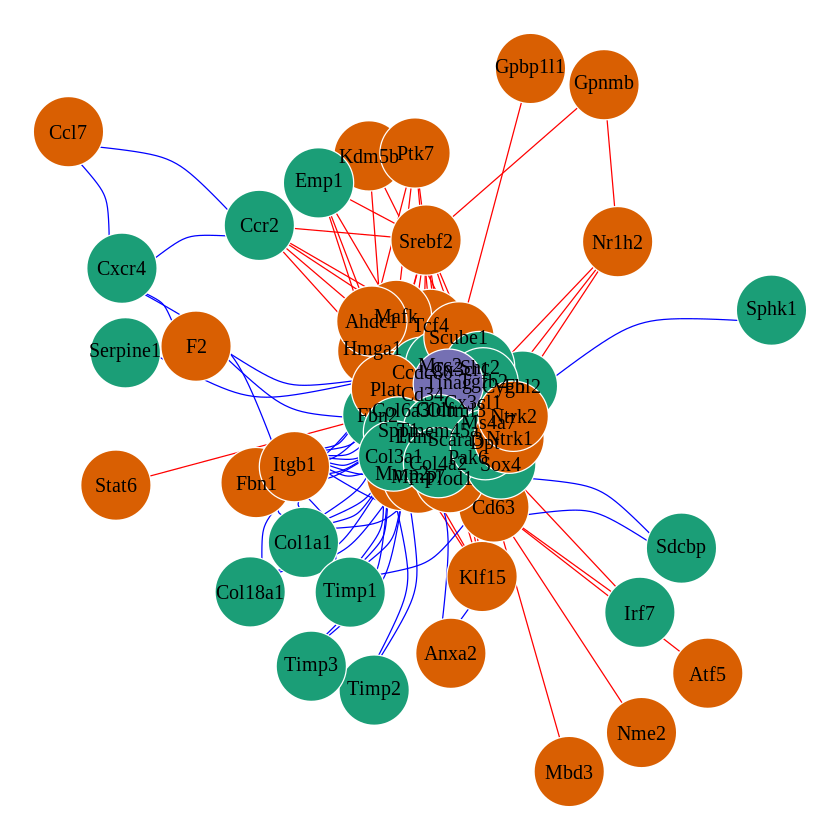

In [166]:
rwr_topresults <-
    create.multiplexNetwork.topResults(rwr_results, multilayer_net, 
      k=50)

library(RColorBrewer)
pal <- brewer.pal(3, "Dark2")

par(mar=c(0.1,0.1,0.1,0.1))
plot(rwr_topresults, vertex.label.color="black",
    vertex.frame.color="#ffffff", vertex.size= 20,
    edge.curved= ifelse(E(rwr_topresults)$type == "PPIN",
                    0.4,0),
    vertex.color = pal[as.numeric(as.factor((E(rwr_topresults)$type)))],
    edge.color=ifelse(E(rwr_topresults)$type == "PPIN",
                      "blue","red"))

In [ ]:
rwr_results_cir <- rwr_results$RWRM_Results

### CPA

In [168]:
gcn_layer_cpa <- gcn_layer %>% filter(node_of_interest %in% c("biomarker_CPA_CIR", "biomarker_CPA", "biomarker_PP_CPA")) %>% select(-node_of_interest) %>% tidyr::drop_na()
tf_cpa_score <- tf_cpa_score %>% tidyr::drop_na()

i_ppin <- graph_from_data_frame(ppi_layer, directed = TRUE)
i_gcn <- graph_from_data_frame(gcn_layer_cpa, directed = TRUE)
i_grn <- graph_from_data_frame(tf_cpa_score, directed = TRUE)

In [169]:
seed_genes <- tf_cpa_score %>% select(from) %>% distinct()
seed_genes <- seed_genes$from
seed_genes

[1] "Hmga1"  "Rxrb"   "Srebf2" "Nr1h2"  "Tcf4"   "Mafk"   "Atf5"   "Ahdc1"

In [170]:
i_ppin <- graph_from_data_frame(ppi_layer, directed = TRUE)
i_gcn <- graph_from_data_frame(gcn_layer_cpa, directed = TRUE)
i_grn <- graph_from_data_frame(grn_layer, directed = TRUE)

In [171]:
multilayer_net <- 
  create.multiplex(list(GRN = i_grn,GCN = i_gcn, PPIN = i_ppin))
adj_matrix <- compute.adjacency.matrix(multilayer_net)
adj_matrix_norm <- normalize.multiplex.adjacency(adj_matrix)
rwr_results <- Random.Walk.Restart.Multiplex(adj_matrix_norm,
                        multilayer_net,seed_genes)

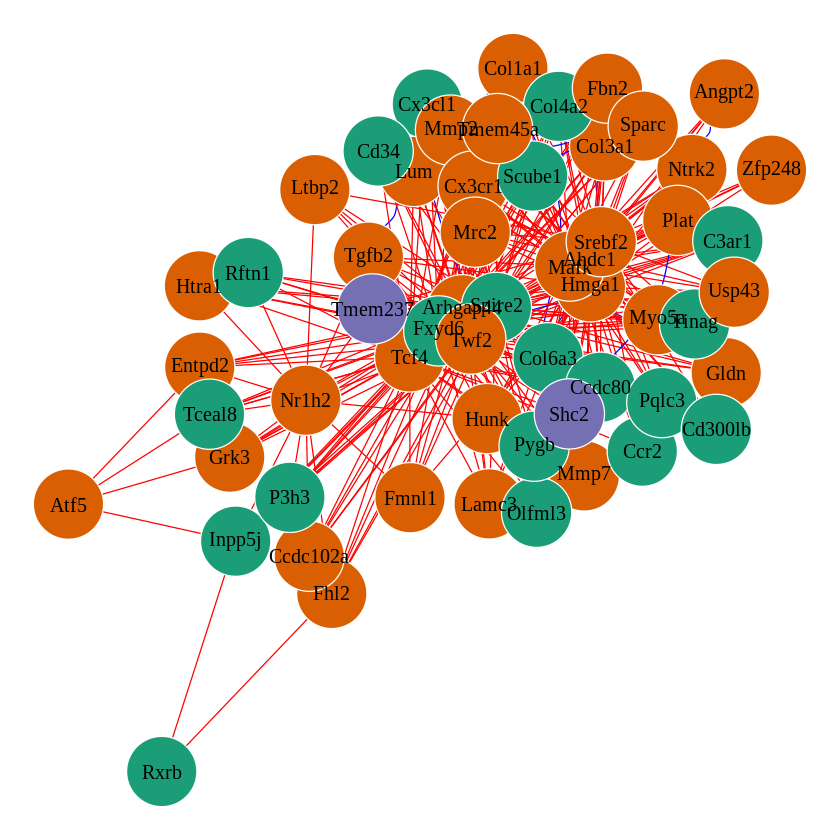

In [172]:
rwr_topresults <-
    create.multiplexNetwork.topResults(rwr_results, multilayer_net, 
      k=50)

library(RColorBrewer)
pal <- brewer.pal(3, "Dark2")

par(mar=c(0.1,0.1,0.1,0.1))
plot(rwr_topresults, vertex.label.color="black",
    vertex.frame.color="#ffffff", vertex.size= 20,
    edge.curved= ifelse(E(rwr_topresults)$type == "PPIN",
                    0.4,0),
    vertex.color = pal[as.numeric(as.factor((E(rwr_topresults)$type)))],
    edge.color=ifelse(E(rwr_topresults)$type == "PPIN",
                      "blue","red"))

In [ ]:
rwr_results_cpa <- rwr_results$RWRM_Results

### RWR score renaming

In [174]:
rwr_results_cir <- rwr_results_cir %>% rename(rwr_score = Score) %>% rename(from = NodeNames)
rwr_results_cpa <- rwr_results_cpa %>% rename(rwr_score = Score) %>% rename(from = NodeNames)
rwr_results_reg <- rwr_results_reg %>% rename(rwr_score = Score) %>% rename(from = NodeNames)
rwr_results_pp <- rwr_results_pp %>% rename(rwr_score = Score) %>% rename(from = NodeNames)

## Hub genes selection

In [225]:
cir_score <- read.csv("03_outputs/14/scores_cir.csv")
cpa_score <- read.csv("03_outputs/14/scores_cpa.csv")
pp_score <- read.csv("03_outputs/14/scores_pp.csv")
reg_score <- read.csv("03_outputs/14/scores_reg.csv")

In [219]:
tfs_reduced <- tfs_scored_combined_prep %>% select(c(from, node_of_interest)) %>% distinct()

In [249]:
cir_scores_df <- merge(cir_score, edge_list_all_prep, by = "from", all = TRUE) %>% mutate(node_of_interest = case_when(
    from %in% tfs_reduced$from ~ "tf", .default = as.character(node_of_interest) 
)) %>% distinct() %>% 
    mutate(node_of_interest = case_when(
    node_of_interest %in% NA ~ "ppi",
    .default = node_of_interest
)) %>% merge(., rwr_results_cir, by = "from", all = TRUE) %>% filter(grepl("CIR|CPA_CIR|tf|ppi" , node_of_interest)) %>% select(-c(to, gcn_weight)) %>% distinct()

cpa_scores_df <- merge(cpa_score, edge_list_all_prep, by = "from", all = TRUE) %>% mutate(node_of_interest = case_when(
    from %in% tfs_reduced$from ~ "tf", .default = as.character(node_of_interest)
)) %>% distinct() %>% 
    mutate(node_of_interest = case_when(
    node_of_interest %in% NA ~ "ppi",
    .default = node_of_interest
)) %>% merge(., rwr_results_cpa, by = "from", all = TRUE) %>% filter(grepl("CPA|CPA_CIR|PP_CPA|tf|ppi" , node_of_interest)) %>% select(-c(to, gcn_weight)) %>% distinct()

pp_scores_df <- merge(pp_score, edge_list_all_prep, by = "from", all = TRUE) %>% mutate(node_of_interest = case_when(
    from %in% tfs_reduced$from ~ "tf", .default = as.character(node_of_interest)
)) %>% distinct() %>% 
    mutate(node_of_interest = case_when(
    node_of_interest %in% NA ~ "ppi",
    .default = node_of_interest
)) %>% merge(., rwr_results_pp, by = "from", all = TRUE) %>% filter(grepl("PP|PP_CPA|tf|ppi" , node_of_interest)) %>% select(-c(to, gcn_weight)) %>% distinct()


reg_scores_df <- merge(reg_score, edge_list_all_prep, by = "from", all = TRUE) %>% mutate(node_of_interest = case_when(
    from %in% tfs_reduced$from ~ "tf", .default = as.character(node_of_interest)
)) %>% distinct() %>% 
    mutate(node_of_interest = case_when(
    node_of_interest %in% NA ~ "ppi",
    .default = node_of_interest
)) %>% merge(., rwr_results_reg, by = "from", all = TRUE) %>% filter(grepl("REG|tf|ppi" , node_of_interest)) %>% select(-c(to, gcn_weight)) %>% distinct()


In [287]:
cir_biomarkers <- cir_scores_df %>% filter(grepl("biomarker", node_of_interest)) %>% mutate(ratio = (cirrhosis_score/DMNC)) %>% distinct() %>% top_n(., 5, ratio)
cir_ppi <- cir_scores_df %>% filter(grepl("ppi", node_of_interest)) %>% top_n(., 10, MNC) %>% top_n(., 5, DMNC)
cir_rwr <- cir_scores_df %>% filter(!node_of_interest == "tf") %>% top_n(., 10, rwr_score) %>% top_n(., 5, DMNC)
cir_tf <- cir_scores_df %>% filter(node_of_interest == "tf") %>% top_n(., 5, DMNC)

reg_biomarkers <- reg_scores_df %>% filter(grepl("biomarker", node_of_interest)) %>% mutate(ratio = (regression_score/DMNC)) %>% distinct() %>% top_n(., 5, ratio)
reg_ppi <- reg_scores_df %>% filter(grepl("ppi", node_of_interest)) %>% top_n(., 10, MNC) %>% top_n(., 5, DMNC)
reg_rwr <- reg_scores_df %>% filter(!node_of_interest == "tf") %>% top_n(., 10, rwr_score) %>% top_n(., 5, DMNC)
reg_tf <- reg_scores_df %>% filter(node_of_interest == "tf") %>% top_n(., 5, DMNC)

pp_biomarkers <- pp_scores_df %>% filter(grepl("biomarker", node_of_interest)) %>% mutate(ratio = (GS.PP/DMNC)) %>% distinct() %>% top_n(., 5, ratio) 
pp_ppi <- pp_scores_df %>% filter(grepl("ppi", node_of_interest)) %>% top_n(., 10, MNC) %>% top_n(., 5, DMNC)
pp_rwr <- pp_scores_df %>% filter(!node_of_interest == "tf") %>% top_n(., 10, rwr_score) %>% top_n(., 5, DMNC)
pp_tf <- pp_scores_df %>% filter(node_of_interest == "tf") %>% top_n(., 5, DMNC)

cpa_biomarkers <- cpa_scores_df %>% filter(grepl("biomarker", node_of_interest)) %>% mutate(ratio = (GS.CPA/DMNC)) %>% distinct() %>% arrange(ratio) %>% top_n(., 5, ratio)
cpa_ppi <- cpa_scores_df %>% filter(grepl("ppi", node_of_interest)) %>% top_n(., 10, EPC) %>% top_n(., 5, DMNC)
cpa_rwr <- cpa_scores_df %>% filter(!node_of_interest == "tf") %>% top_n(., 10, rwr_score) %>% top_n(., 5, DMNC)
cpa_tf <- cpa_scores_df %>% filter(node_of_interest == "tf") %>% top_n(., 5, DMNC)

In [288]:
cir_hub <- merge(cir_biomarkers, cir_ppi, all = TRUE) %>% merge(., cir_rwr, all = TRUE) %>% merge(., cir_tf, all = TRUE)
reg_hub <- merge(reg_biomarkers, reg_ppi, all = TRUE) %>% merge(., reg_rwr, all = TRUE) %>% merge(., reg_tf, all = TRUE)
pp_hub <- merge(pp_biomarkers, pp_ppi, all = TRUE) %>% merge(., pp_rwr, all = TRUE) %>% merge(., pp_tf, all = TRUE)
cpa_hub <- merge(cpa_biomarkers, cpa_ppi, all = TRUE) %>% merge(., cpa_rwr, all = TRUE) %>% merge(., cpa_tf, all = TRUE)

### Outputs

In [290]:
write.csv(cir_hub, "03_outputs/14/cir_hub.csv")
write.csv(reg_hub, "03_outputs/14/reg_hub.csv")
write.csv(pp_hub, "03_outputs/14/pp_hub.csv")
write.csv(cpa_hub, "03_outputs/14/cpa_hub.csv")